In [1]:
# 05_Model_Evaluation.ipynb

import pandas as pd
import numpy as np
import json
import os
import re
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# --- Konfigurasi Path (sesuaikan dengan struktur proyek Anda) ---
BASE_DRIVE_PATH = "/content/drive/MyDrive/Semester 6/PK/UAS" # Sesuaikan jika berbeda
PATH_EVAL_DATA = os.path.join(BASE_DRIVE_PATH, "data/eval")
PATH_RESULTS = os.path.join(BASE_DRIVE_PATH, "data/results")
PATH_PROCESSED_DATA = os.path.join(BASE_DRIVE_PATH, "data/processed")


# File input dari tahap-tahap sebelumnya
QUERIES_JSON_FILE = os.path.join(PATH_EVAL_DATA, "queries.json")
PREDICTIONS_CSV_FILE = os.path.join(PATH_RESULTS, "predictions.csv")

# File output untuk tahap ini
RETRIEVAL_METRICS_CSV = os.path.join(PATH_EVAL_DATA, "retrieval_metrics.csv")
PREDICTION_METRICS_CSV = os.path.join(PATH_EVAL_DATA, "prediction_metrics.csv")

In [4]:
# --- 1. Muat Data Ground Truth dan Hasil Prediksi ---
print("Memuat data ground truth dan hasil prediksi...")

try:
    # Muat ground truth queries
    with open(QUERIES_JSON_FILE, 'r', encoding='utf-8') as f:
        ground_truth_queries = json.load(f)
    df_ground_truth = pd.DataFrame(ground_truth_queries)
    print(f"Berhasil memuat {len(df_ground_truth)} queries dari {QUERIES_JSON_FILE}")
except FileNotFoundError:
    print(f"Error: File ground truth {QUERIES_JSON_FILE} tidak ditemukan.")
    exit()

try:
    # Muat hasil prediksi dan retrieval dari Tahap 4
    df_predictions = pd.read_csv(PREDICTIONS_CSV_FILE)
    # Konversi kolom 'top_5_case_ids' dari string JSON kembali ke list
    df_predictions['top_5_case_ids'] = df_predictions['top_5_case_ids'].apply(json.loads)
    print(f"Berhasil memuat {len(df_predictions)} hasil prediksi dari {PREDICTIONS_CSV_FILE}")
except FileNotFoundError:
    print(f"Error: File hasil prediksi {PREDICTIONS_CSV_FILE} tidak ditemukan. Pastikan Tahap 4 sudah dijalankan.")
    exit()

# Gabungkan ground truth dan hasil prediksi berdasarkan query_id
df_eval = pd.merge(df_ground_truth, df_predictions, on="query_id", how="left")

if df_eval.empty:
    print("DataFrame evaluasi kosong setelah digabung. Periksa 'query_id' di kedua file.")
    exit()

print("\nData gabungan untuk evaluasi:")
print(df_eval)

Memuat data ground truth dan hasil prediksi...
Berhasil memuat 3 queries dari /content/drive/MyDrive/Semester 6/PK/UAS/data/eval/queries.json
Berhasil memuat 3 hasil prediksi dari /content/drive/MyDrive/Semester 6/PK/UAS/data/results/predictions.csv

Data gabungan untuk evaluasi:
  query_id                                         query_text  \
0     Q001  Suami meninggalkan istri dan anak lebih dari d...   
1     Q002  Terjadi perselisihan dan pertengkaran terus me...   
2     Q003           Salah satu pihak melakukan penganiayaan.   

                                   relevant_case_ids      correct_outcome  \
0             [2, 4, 10, 12, 14, 22, 23, 29, 34, 35]  MENGABULKAN GUGATAN   
1  [1, 2, 3, 4, 7, 10, 12, 14, 21, 22, 23, 25, 29...  MENGABULKAN GUGATAN   
2                              [1, 2, 7, 10, 14, 21]            LAIN-LAIN   

  predicted_solution       top_5_case_ids  
0          LAIN-LAIN   [30, 2, 29, 7, 23]  
1          LAIN-LAIN  [2, 30, 22, 23, 12]  
2          LAIN-L

In [5]:
# --- 2. Evaluasi Retrieval (Precision, Recall, F1-Score @k) ---
print("\n--- Mengevaluasi Kinerja Retrieval ---")

def eval_retrieval(retrieved_ids, relevant_ids_ground_truth):
    """
    Menghitung metrik Precision@k, Recall@k, dan F1-Score@k untuk satu query.
    k adalah jumlah item yang di-retrieve (panjang dari retrieved_ids).
    """
    if not relevant_ids_ground_truth: # Jika tidak ada ground truth, metrik tidak bisa dihitung
        return 0, 0, 0, 0

    # Ubah ke set untuk irisan yang efisien
    retrieved_set = set(retrieved_ids)
    relevant_set = set(relevant_ids_ground_truth)

    true_positives = len(retrieved_set.intersection(relevant_set))

    # Precision@k = (Jumlah item relevan yang diambil) / k
    k = len(retrieved_ids)
    precision = true_positives / k if k > 0 else 0

    # Recall@k = (Jumlah item relevan yang diambil) / (Total item relevan di ground truth)
    total_relevant = len(relevant_set)
    recall = true_positives / total_relevant if total_relevant > 0 else 0

    # F1-Score@k
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0

    # Accuracy (didefinisikan sebagai: apakah setidaknya satu dokumen relevan ditemukan?)
    accuracy = 1 if true_positives > 0 else 0

    return precision, recall, f1, accuracy

retrieval_metrics = []
for index, row in df_eval.iterrows():
    retrieved = row['top_5_case_ids']
    relevant = row['relevant_case_ids']

    # Pastikan 'relevant_case_ids' ada dan tidak kosong di queries.json
    if not isinstance(relevant, list) or not relevant:
        print(f"Peringatan: 'relevant_case_ids' untuk query_id '{row['query_id']}' kosong atau tidak valid. Retrieval tidak bisa dievaluasi untuk query ini.")
        continue

    precision_k, recall_k, f1_k, acc = eval_retrieval(retrieved, relevant)
    retrieval_metrics.append({
        "query_id": row['query_id'],
        "precision_at_5": precision_k,
        "recall_at_5": recall_k,
        "f1_score_at_5": f1_k,
        "accuracy_at_5": acc
    })

df_retrieval_metrics = pd.DataFrame(retrieval_metrics)

print("\nMetrik Retrieval per Query:")
print(df_retrieval_metrics)

# Hitung rata-rata metrik (Macro Average)
avg_metrics = df_retrieval_metrics.mean(numeric_only=True)
print("\nRata-rata Metrik Retrieval (Macro Average):")
print(avg_metrics)

# Simpan hasil metrik retrieval ke CSV
df_retrieval_metrics.to_csv(RETRIEVAL_METRICS_CSV, index=False)
print(f"\nMetrik retrieval disimpan ke: {RETRIEVAL_METRICS_CSV}")


--- Mengevaluasi Kinerja Retrieval ---

Metrik Retrieval per Query:
  query_id  precision_at_5  recall_at_5  f1_score_at_5  accuracy_at_5
0     Q001             0.6     0.300000       0.400000              1
1     Q002             1.0     0.277778       0.434783              1
2     Q003             0.6     0.500000       0.545455              1

Rata-rata Metrik Retrieval (Macro Average):
precision_at_5    0.733333
recall_at_5       0.359259
f1_score_at_5     0.460079
accuracy_at_5     1.000000
dtype: float64

Metrik retrieval disimpan ke: /content/drive/MyDrive/Semester 6/PK/UAS/data/eval/retrieval_metrics.csv


In [6]:
# --- 3. Evaluasi Prediksi Solusi ---
print("\n--- Mengevaluasi Kinerja Prediksi Solusi ---")

# PENTING: Anda harus menambahkan kolom "correct_outcome" secara manual
# ke file queries.json Anda untuk evaluasi ini.
# Kolom ini harus berisi kategori solusi yang benar untuk setiap query.
# Contoh: "correct_outcome": "MENGABULKAN GUGATAN"

if 'correct_outcome' not in df_eval.columns:
    print("Peringatan: Kolom 'correct_outcome' tidak ditemukan di data ground truth.")
    print("Evaluasi prediksi solusi tidak dapat dilakukan.")
    print("Silakan tambahkan 'correct_outcome' ke file queries.json Anda dan jalankan ulang.")
else:
    # Filter baris yang tidak memiliki ground truth untuk prediksi
    df_pred_eval = df_eval.dropna(subset=['correct_outcome', 'predicted_solution'])

    if not df_pred_eval.empty:
        y_true = df_pred_eval['correct_outcome']
        y_pred = df_pred_eval['predicted_solution']

        # Dapatkan semua label unik yang ada
        labels = sorted(list(set(y_true) | set(y_pred)))

        print("\nClassification Report untuk Prediksi Solusi:")
        report = classification_report(y_true, y_pred, labels=labels, zero_division=0)
        print(report)

        # Hitung metrik agregat
        accuracy = accuracy_score(y_true, y_pred)
        precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0, labels=labels)
        recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0, labels=labels)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0, labels=labels)

        prediction_metrics_summary = {
            "accuracy": accuracy,
            "precision_macro": precision_macro,
            "recall_macro": recall_macro,
            "f1_score_macro": f1_macro
        }

        df_prediction_metrics = pd.DataFrame([prediction_metrics_summary])

        print("\nRingkasan Metrik Prediksi Solusi:")
        print(df_prediction_metrics)

        # Simpan hasil metrik prediksi ke CSV
        df_prediction_metrics.to_csv(PREDICTION_METRICS_CSV, index=False)
        print(f"\nMetrik prediksi solusi disimpan ke: {PREDICTION_METRICS_CSV}")
    else:
        print("Tidak ada data yang valid untuk evaluasi prediksi (pastikan kolom 'correct_outcome' dan 'predicted_solution' terisi).")


--- Mengevaluasi Kinerja Prediksi Solusi ---

Classification Report untuk Prediksi Solusi:
                     precision    recall  f1-score   support

          LAIN-LAIN       0.33      1.00      0.50         1
MENGABULKAN GUGATAN       0.00      0.00      0.00         2

           accuracy                           0.33         3
          macro avg       0.17      0.50      0.25         3
       weighted avg       0.11      0.33      0.17         3


Ringkasan Metrik Prediksi Solusi:
   accuracy  precision_macro  recall_macro  f1_score_macro
0  0.333333         0.166667           0.5            0.25

Metrik prediksi solusi disimpan ke: /content/drive/MyDrive/Semester 6/PK/UAS/data/eval/prediction_metrics.csv



--- Visualisasi & Analisis Kegagalan ---


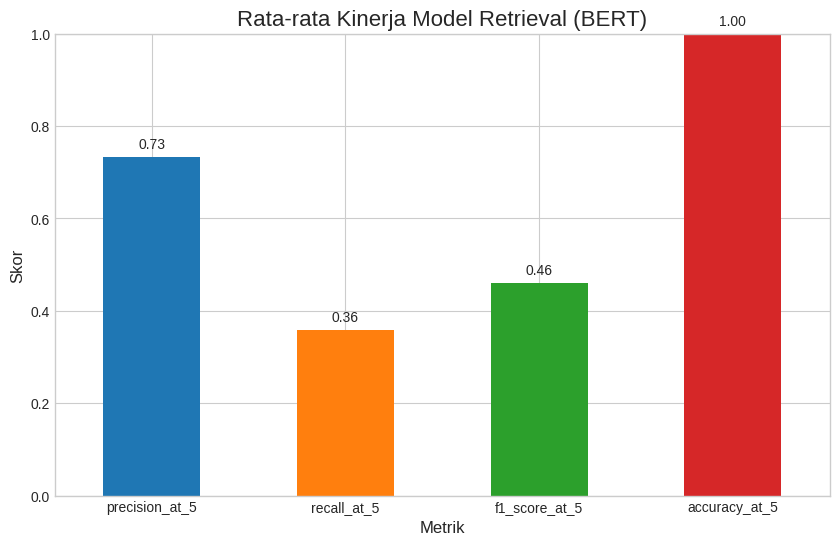


Analisis Kegagalan (Panduan untuk Laporan):
--------------------------------------------------
1. Analisis Kegagalan Retrieval:
   - Lihat query dengan skor Precision/Recall@5 terendah dari tabel 'Metrik Retrieval per Query'.
   - Untuk query tersebut, bandingkan 'top_5_case_ids' yang diambil sistem dengan 'relevant_case_ids' dari ground truth.
   - Jawab pertanyaan berikut:
     - Kasus mana yang salah diambil (False Positive)? Mengapa sistem menganggapnya mirip? Apakah karena kesamaan kata kunci yang dangkal?
     - Kasus mana yang seharusnya diambil tapi terlewat (False Negative)? Mengapa sistem gagal melihat kemiripannya? Apakah karena penggunaan sinonim atau frasa yang berbeda?
   - Contoh Analisis: 'Untuk query Q002, sistem mengambil kasus 23 yang tidak relevan. Ini terjadi karena kasus 23 mengandung kata kunci 'perselisihan' meskipun konteksnya berbeda. Sistem juga gagal mengambil kasus 45 yang relevan, kemungkinan karena kasus 45 menggunakan istilah 'cekcok' daripada 'pertengk

In [7]:
# --- 4. Visualisasi & Analisis Kegagalan ---
print("\n--- Visualisasi & Analisis Kegagalan ---")

# Visualisasi Kinerja Retrieval (Opsional)
if not df_retrieval_metrics.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    avg_metrics.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_title('Rata-rata Kinerja Model Retrieval (BERT)', fontsize=16)
    ax.set_ylabel('Skor', fontsize=12)
    ax.set_xlabel('Metrik', fontsize=12)
    ax.set_xticklabels(avg_metrics.index, rotation=0)
    ax.set_ylim(0, 1) # Set limit y-axis antara 0 dan 1

    # Tambahkan label nilai di atas bar
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.show()

# Analisis Kegagalan (Error Analysis) - Bagian kualitatif untuk laporan Anda
# Anda perlu mengisi analisis ini secara manual berdasarkan hasil.

print("\nAnalisis Kegagalan (Panduan untuk Laporan):")
print("-" * 50)
print("1. Analisis Kegagalan Retrieval:")
print("   - Lihat query dengan skor Precision/Recall@5 terendah dari tabel 'Metrik Retrieval per Query'.")
print("   - Untuk query tersebut, bandingkan 'top_5_case_ids' yang diambil sistem dengan 'relevant_case_ids' dari ground truth.")
print("   - Jawab pertanyaan berikut:")
print("     - Kasus mana yang salah diambil (False Positive)? Mengapa sistem menganggapnya mirip? Apakah karena kesamaan kata kunci yang dangkal?")
print("     - Kasus mana yang seharusnya diambil tapi terlewat (False Negative)? Mengapa sistem gagal melihat kemiripannya? Apakah karena penggunaan sinonim atau frasa yang berbeda?")
print("   - Contoh Analisis: 'Untuk query Q002, sistem mengambil kasus 23 yang tidak relevan. Ini terjadi karena kasus 23 mengandung kata kunci 'perselisihan' meskipun konteksnya berbeda. Sistem juga gagal mengambil kasus 45 yang relevan, kemungkinan karena kasus 45 menggunakan istilah 'cekcok' daripada 'pertengkaran' yang ada di query.'")
print("\n2. Analisis Kegagalan Prediksi Solusi:")
print("   - Lihat query di mana 'predicted_solution' tidak sama dengan 'correct_outcome'.")
print("   - Jawab pertanyaan berikut:")
print("     - Apakah kegagalan prediksi disebabkan oleh kegagalan retrieval (kasus yang diambil tidak relevan)?")
print("     - Atau, apakah kasus yang diambil sudah relevan, tetapi 'voting' di antara mereka menghasilkan kategori yang salah? (misalnya, 3 dari 5 kasus relevan punya amar 'MENOLAK' padahal yang benar 'MENGABULKAN').")
print("   - Contoh Analisis: 'Prediksi untuk Q001 salah (diprediksi MENGABULKAN, seharusnya MENOLAK). Ini terjadi karena 4 dari 5 kasus teratas yang diambil oleh sistem memiliki amar MENGABULKAN, meskipun kasus-kasus tersebut kurang relevan. Ini menunjukkan masalah pada tahap retrieval.'")

print("\n--- Tahap 5 Selesai ---")